In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [155]:
#导入数据
IF = pd.read_excel('data_IH.xlsx',sheet_name = 'ih')

In [196]:
# IF_ = IF['收盘价(元)'].values
IF_ = pd.read_csv('wden_ih.csv',header=None)

In [197]:
IF_close = (np.array(IF_[1:])-np.array(IF_[0:-1]))
IF_close = IF_close/np.linalg.norm(IF_close)

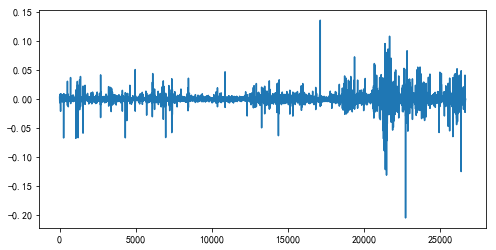

In [198]:
plt.plot(IF_close)

In [140]:
def FPE(train, a):
    k = len(a)
    n= len(train)
    sigma = 0.0
    S = 0.0
    #calculate sum of residual square
    for  t in range(k,n):
        model = np.sum([a[i]*train[t-i-1] for i in range(0,k)])
        resid = train[t]-model
#         print(model,train[t],resid)
        S = S + resid**2
    fpe = (n+k+1)*S/(n-k-1)
    return(fpe)

In [9]:
def find_k(train):
    mult_a = []
    mult_fpe = np.empty(8)
    for i in range(2,10):
        a = burgs(train,i)
        mult_a.append(a)
        mult_fpe[i-2] = FPE(train,a)
    
    argmin = np.where(mult_fpe==min(mult_fpe))[0][0]
#     return(argmin+2,mult_a[argmin],mult_fpe[argmin])
    return(argmin+2,mult_a[argmin])
#     return(argmin+2)

In [51]:
find_k(IF_close[12380:12420])

(9, array([ 1.05215422, -0.15835509,  0.26207459, -0.41576266,  0.38309054,
        -0.09063698, -0.16598233, -0.43213051,  0.51283054]))

In [211]:
#已弃用
def yule_walker(x,k):
    N = len(x)
    m = np.mean(x)
    p_hat = np.empty(k+1)
    for i in range(0,k+1):
        prod = np.multiply(x[i+1:N]-m,x[1:N-i]-m)
        p_hat[i] = np.sum(prod)/N
    
    A = np.fromfunction(lambda i,j: 
                        np.where(i<j,p_hat[j-i],np.where(i>j,p_hat[i-j],p_hat[0])),
                        (k,k),dtype=int)
    b = p_hat[1:k+1]
    a = np.linalg.solve(A,b)
    return(a)#return a1,a2,...,ak

In [141]:
def sigma_2(x,p):
    t=len(x)
    data=x.T
    data1=np.mat(data)
    g=p+1
    e=np.mat(np.zeros((p+1,t)))
    b=np.mat(np.zeros((p+1,t)))
    ss=np.mat(np.zeros((1,p+1)))
    aa=np.mat(np.zeros((p,p)))
    k1=np.zeros(p)
    e[0,:]=data
    b[0,:]=data
    ss[0,0]=np.mean(np.multiply(data1,data1),axis=1)
    for k in range(0,p):
        if k==0:
            h1=e[k,k+1:t]
            h2=b[k,k:t-1]
            hh=np.sum(np.multiply(h1,h2))
            hhh=np.sum(np.multiply(h1,h1)+np.multiply(h2,h2))
            k1[k]=-2*hh/hhh
        else:
            h11=e[k,k:t]
            h22=b[k,k-1:t-1]
            hh1=np.sum(np.multiply(h11,h22))
            hhh1=np.sum(np.multiply(h11,h11)+np.multiply(h22,h22))
            k1[k]=-2*hh1/hhh1

        if k>0:
            for i in range(0,k):
                aa[k,i]=aa[k-1,i]+k1[k]*aa[k-1,k-i-1]
        aa[k,k]=k1[k]
        
        for r in range(0,t):
            if r==0:
                e[k+1,r]=e[k,r]
                b[k+1,r]=k1[k]*e[k,r]
            else:
                e[k+1,r]=e[k,r]+k1[k]*b[k,r-1]
                b[k+1,r]=b[k,r-1]+k1[k]*e[k,r]
        ss[0,k+1]=(1-k1[k]**2)*ss[0,k]
    return(ss[0][0,-1],-np.array(aa[p-1,:])[0])
#     return(ss[0][0,-1])

In [142]:
# a = sigma_2(IF_close[0:40],2)[1]
# FPE(IF_close[4760:4800],a),a
sigma_2(IF_close[100:140],2)

(1.6111020063327995e-05, array([-0.01069108, -0.32881209]))

In [204]:
def burgs(x,k):
    N = len(x)
    f = x[1:N]
    b = x[0:N-1]
    mu = -(2*b.T@f)/(f.T@f+b.T@b)
    a = np.array([1,0])
    ss = np.mean(np.multiply(x,x))
    for i in range(1,k+1):
        J = np.fromfunction(lambda m,n: np.where(m+n==i,1,0), (i+1,i+1))
        f = np.array([a.T@J@x[h-i:h+1] for h in range(i,N)])
        b = np.array([a.T@x[h-i:h+1] for h in range(i,N)])
        mu = -(2*b.T@f)/(f.T@f+b.T@b)
        a = a + mu*J@a
        a = np.concatenate([a,[0]])
        ss = (1-mu**2)*ss
#     return(-a[1:-1],ss[0][0])
    return(-a[1:-1])

In [145]:
def spectral_density(sigma_a, a, f):
    k = len(a)
    S = 2*sigma_a/np.power(abs(1-np.sum([a[h-1]*np.exp(-2*1j*np.pi*f*h) for h in range(1,k+1)])),2)
    return(S)

In [199]:
#收益率计算
#2016年IF_close
#IH
index =(IF['日期'].dt.year == 2016)
data = IF_close[index[:-1]]
#IC
# data = IF_close[0:8764]
#IF
# data = IF_close[0:9864]
# profit = pd.DataFrame({'profit_rate':[],'sell':[],'sell_time':[],'buy':[],'buy_time':[]})
profit_rate = []
sell = []
sell_time = []
buy = []
buy_time = []
diff = []
acc_profit2016 = 0.0

MA10 = np.zeros(len(data))
freq_list = np.empty(len(data))
cyc_list = np.empty(len(data))
n = 40
k = 2
f = np.linspace(0.01,0.99,200)

for i in range(n,len(data)):
#     k,a,fpe = find_k(data[i-n+1:i+1])
    a,sigma = burgs(data[i-n:i],k)
    print(sigma,a)
#     sigma = sigma_2(data[i-n:i],k)[0]
    y = map(lambda x: spectral_density(sigma,a,x),f)
    y = list(y)
    freq_list[i] = f[np.where(y==max(y))][0]
    cyc_list[i] = 1/freq_list[i]
    if(i >= n+10):
        MA10[i] = min(max(np.mean(cyc_list[i-10:i]),5),30)
        if((MA10[i]>=10) & (MA10[i-1]<10)):#上穿买入
#         if((cyc_list[i]>=10) & (cyc_list[i-1]<10)):
#             print('buy')
            buy_ = IF['收盘价(元)'].values[i-1]
            buy_time_ = i
            if(len(sell)>0):
                buy.append(-sell_)
                buy_time.append(sell_time_)
                sell.append(-buy_)
                sell_time.append(buy_time_)
                profit_rate.append(sell_/buy_-1)
                acc_profit2016 = acc_profit2016 + sell_- buy_
        if((MA10[i]<=10)& (MA10[i-1]>10)):#下穿卖出
#         if((cyc_list[i]<=10) & (cyc_list[i-1]>10)):
#             print('sell')
            sell_ = IF['收盘价(元)'].values[i-1]
            sell_time_ = i
            buy.append(buy_)
            buy_time.append(buy_time_)            
            sell.append(sell_)
            sell_time.append(sell_time_)
            profit_rate.append(sell_/buy_-1)
            acc_profit2016 = acc_profit2016 + sell_- buy_

7.239793179665475e-06 [ 0.79333027 -0.27517136]
7.12085047814371e-06 [ 0.84312345 -0.36935363]
7.125658526296502e-06 [ 0.84959827 -0.36716568]
7.3847795131357604e-06 [ 0.84085562 -0.31756775]
7.682312720213806e-06 [ 0.81524369 -0.31355248]
7.655964170941206e-06 [ 0.82198257 -0.32708966]
7.6949396975654e-06 [ 0.81848529 -0.32756626]
7.710119430591992e-06 [ 0.81488786 -0.31515671]
7.669404621205851e-06 [ 0.80295185 -0.3219008 ]
7.439897619362258e-06 [ 0.79162687 -0.34938972]
7.464583196969093e-06 [ 0.74601807 -0.33800978]
6.485464629108423e-06 [ 0.78176906 -0.28494185]
6.5225745494883585e-06 [ 0.78013487 -0.28322045]
6.2052898760395774e-06 [ 0.79764318 -0.32531733]
6.235850704648963e-06 [ 0.79210718 -0.32644927]
5.8191421346008365e-06 [ 0.8152873  -0.30444313]
5.990580167114261e-06 [ 0.79961131 -0.31281069]
5.911748721346971e-06 [ 0.81805036 -0.33541555]
5.913776018030212e-06 [ 0.82622799 -0.33654044]
6.01171650554798e-06 [ 0.82717931 -0.32449839]
6.002768041598877e-06 [ 0.83057005 -0.32

1.5294888139392864e-06 [ 0.93015608 -0.33537784]
1.5333534743381203e-06 [ 0.92750262 -0.33404645]
1.5610273268191814e-06 [ 0.9142775  -0.32085712]
1.4948807725480828e-06 [ 0.92149521 -0.28757217]
1.5296398624685906e-06 [ 0.90520176 -0.28707551]
1.5051085145312683e-06 [ 0.90212803 -0.31321717]
1.50664732139378e-06 [ 0.87488245 -0.31353626]
1.149547818255885e-06 [ 0.90969778 -0.20119358]
1.1470593218460647e-06 [ 0.90420096 -0.20297514]
1.0657298131293505e-06 [ 0.92844128 -0.26287242]
1.0775367758835822e-06 [ 0.90457167 -0.26506791]
8.497732744873896e-07 [ 0.9085531  -0.17923977]
8.188065981423311e-07 [ 0.93665486 -0.20480706]
7.677168219186753e-07 [ 0.96405259 -0.23472587]
7.675679104098085e-07 [ 0.96211567 -0.23310631]
7.646200490819971e-07 [ 0.96197958 -0.23769339]
1.0966259101026754e-06 [ 0.85973473 -0.18563084]
1.1437037398081159e-06 [ 0.99671262 -0.30083278]
1.132527753301176e-06 [ 1.05708543 -0.30900264]
1.135771887006346e-06 [ 1.0625085  -0.24611597]
1.6445090955191219e-06 [ 0.942

KeyboardInterrupt: 

In [152]:
profit2016 = pd.DataFrame({'profit_rate':profit_rate,'sell':sell,'sell_time':sell_time,
                           'buy':buy,'buy_time':buy_time,
                           'cum_profit_rate':np.cumsum(profit_rate)})
acc_profit2016,np.sum(profit2016['profit_rate']),len(profit2016)
#2016累计收益点数,累计收益率,交易次数

(-178.600000000004, -0.07385521971632436, 160)

In [66]:
np.sum(profit2016['profit_rate']<0)

88

In [68]:
hh = profit2016.iloc[np.where(profit2016['profit_rate']<0)[0]]
np.mean(hh['profit_rate'])
# np.mean(profit2016['profit_rate'])

-0.007415917160350962

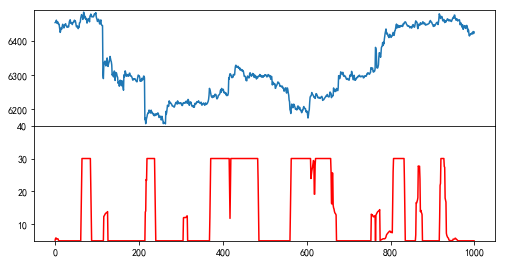

In [73]:
fig = plt.figure()
data = IF['收盘价(元)'].values[5000:6000]
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(min(data)-5, max(data)+5))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(5, 40))
ax1.plot(data)
ax2.plot(MA10[5000:6000],'r')

Text(0.5,1,'2016IC: 净值增长 vs 标的价格')

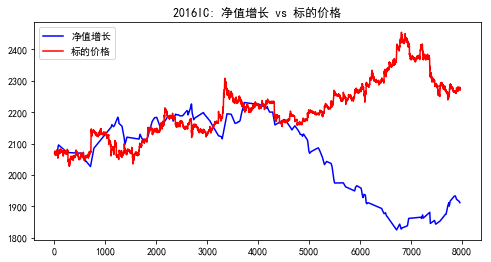

In [153]:
# nn = np.concatenate([[0],neg_profit_rate])
plt.plot(profit2016['sell_time'],(profit2016['profit_rate']+1).cumprod()*IF['收盘价(元)'].values[0]
         ,'b',IF['收盘价(元)'].values[0:7964],'r')
plt.rcParams['figure.figsize'] = (8, 4) 
plt.legend(['净值增长','标的价格'])
plt.title('2016IC: 净值增长 vs 标的价格')

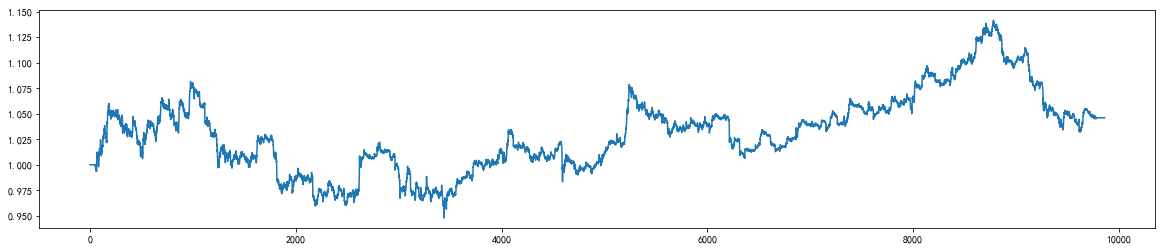

In [175]:
#2016净值曲线
data = IF['收盘价(元)'].values[0:9864]
aa= np.ones(len(data))
net_value = np.empty(len(data))
for i in range(len(profit2016)):
    b_time = profit2016['buy_time'].iloc[i]
    s_time = profit2016['sell_time'].iloc[i]
    price = data[b_time:s_time]
    growth_rate = (price[1:]-price[0:-1])/price[0:-1]
    aa[b_time+1:s_time] = 1.0+growth_rate

for j in range(len(data)):
    net_value[j] = aa[0:j].prod()
    
# plt.plot(net_value)
plt.plot(net_value)

In [103]:
#收益率计算
#2017年IF_close[0：10854]
#IC
index =(IF['日期'].dt.year == 2017)
data = IF_close[index[0:-1]]
#IH
# data = IF_close[7964:20064]
#IF
# data = IF_close[9864:21964]
# profit = pd.DataFrame({'profit_rate':[],'sell':[],'sell_time':[],'buy':[],'buy_time':[]})
profit_rate = []
sell = []
sell_time = []
buy = []
buy_time = []
diff = []
acc_profit2017 = 0.0

MA10 = np.zeros(len(data))
freq_list = np.empty(len(data))
cyc_list = np.empty(len(data))
n = 40
k = 2
f = np.linspace(0.01,0.99,200)

for i in range(n,len(data)):
#     k,a,fpe = find_k(data[i-n+1:i+1])
    a = burgs(data[i-n:i],k)
#     fpe = FPE(data[i-n+1:i+1],a)
    sigma = sigma_2(data[i-n:i],k)[0]
    y = map(lambda x: spectral_density(sigma,a,x),f)
    y = list(y)
    freq_list[i] = f[np.where(y==max(y))][0]
    cyc_list[i] = 1/freq_list[i]
    if(i >= n+10):
        MA10[i] = min(max(np.mean(cyc_list[i-10:i]),5),30)
        if((MA10[i]>=10) & (MA10[i-1]<10)):#上穿买入
#         if((cyc_list[i]>=10) & (cyc_list[i-1]<10)):
#             print('buy')
            buy_ = IF['收盘价(元)'].values[9864+i-1]
            buy_time_ = i
            if(len(sell)>0):
                buy.append(-sell_)
                buy_time.append(sell_time_)
                sell.append(-buy_)
                sell_time.append(buy_time_)
                profit_rate.append(sell_/buy_-1)
                acc_profit2017 = acc_profit2017 + sell_- buy_
        if((MA10[i]<=10)& (MA10[i-1]>10)):#下穿卖出
#         if((cyc_list[i]<=10) & (cyc_list[i-1]>10)):
#             print('sell')
            sell_ = IF['收盘价(元)'].values[9864+i-1]
            sell_time_ = i
            buy.append(buy_)
            buy_time.append(buy_time_)            
            sell.append(sell_)
            sell_time.append(sell_time_)
            profit_rate.append(sell_/buy_-1)
            acc_profit2017 = acc_profit2017 + sell_- buy_

In [104]:
profit2017 = pd.DataFrame({'profit_rate':profit_rate,'sell':sell,'sell_time':sell_time,
                           'buy':buy,'buy_time':buy_time,
                           'accum_profit_rate':np.cumsum(profit_rate)})
acc_profit2017,np.sum(profit2017['profit_rate']),len(profit2017) 
#2017累计收益点数,累计收益率,交易次数

(85.40000000000418, 0.03276912046280411, 296)

In [105]:
np.sum(profit2017['profit_rate']>0)

141

In [101]:
hh = profit2017.iloc[np.where(profit2017['profit_rate']>0)[0]]
np.mean(hh['profit_rate'])
# np.mean(profit2017['profit_rate'])

0.0048939528457086524

In [230]:
len(IF['收盘价(元)'].values[8764:20864])

12100

Text(0.5,1,'2017IC: 净值增长 vs 标的价格')

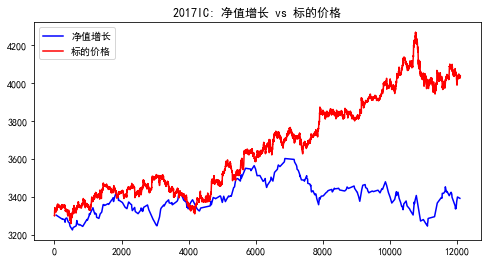

In [106]:
# nn = np.concatenate([[0],neg_profit_rate])
# nn = neg_profit_rate
plt.plot(profit2017['sell_time'],(profit2017['profit_rate']+1).cumprod()*IF['收盘价(元)'].values[9864]
         ,'b',IF['收盘价(元)'].values[9864:21964],'r')
plt.legend(['净值增长','标的价格'])
plt.title('2017IC: 净值增长 vs 标的价格')

In [ ]:
#收益率计算
#2018年
#IF 0.05
# data = IF_close[21964:]
#IC 0.22
index =(IF['日期'].dt.year == 2018)
values = IF['收盘价(元)'].values[index]
data = IF_close[20064:]
#IH 0.089
# data = IF_close[20064:]
profit_rate = []
sell = []
sell_time = []
buy = []
buy_time = []
acc_profit2018 = 0.0

neg_buy = []
neg_sell = []
neg_profit_rate = []

MA10 = np.zeros(len(data))
freq_list = np.empty(len(data))
cyc_list = np.empty(len(data))
n = 40
k = 2
f = np.linspace(0.01,0.99,200)

for i in range(n,len(data)):
#     k,a = find_k(data[i-n:i])
    a = burgs(data[i-n:i],k)
#     fpe = FPE(data[i-n+1:i+1],a)
    sigma = sigma_2(data[i-n:i],k)[0]
#     sigma = np.std(a)
    y = map(lambda x: spectral_density(sigma,a,x),f)
    y = list(y)
    freq_list[i] = f[np.where(y==max(y))][0]
    cyc_list[i] = 1/freq_list[i]
    if(i >= n+10):
        MA10[i] = min(max(np.mean(cyc_list[i-10:i]),5),30)
        if((MA10[i]>=10) & (MA10[i-1]<10)):#上穿买入
#         if((cyc_list[i]>=10) & (cyc_list[i-1]<10)):
#             print('buy')
            buy_ = IF['收盘价(元)'].values[20064+i-1]
            buy_time_ = i
            if(len(sell)>0):
                buy.append(-sell_)
                buy_time.append(sell_time_)
                sell.append(-buy_)
                sell_time.append(buy_time_)
                profit_rate.append(sell_/buy_-1)
                acc_profit2018 = acc_profit2018 + sell_- buy_
        if((MA10[i]<=10)& (MA10[i-1]>10)):#下穿卖出
#         if((cyc_list[i]<=10) & (cyc_list[i-1]>10)):
#             print('sell')
            sell_ = IF['收盘价(元)'].values[20064+i-1]
            sell_time_ = i
            buy.append(buy_)
            buy_time.append(buy_time_)            
            sell.append(sell_)
            sell_time.append(sell_time_)
            profit_rate.append(sell_/buy_-1)
            acc_profit2018 = acc_profit2018 + sell_- buy_
    if(i%500==0):
        print(i)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [208]:
profit2018 = pd.DataFrame({'profit_rate':profit_rate,'sell':sell,'sell_time':sell_time,'buy':buy,'buy_time':buy_time})
acc_profit2018,np.sum(profit2018['profit_rate']),len(profit2018) 
#2018累计收益点数,累计收益率,交易次数

(139.200000000003, 0.045916213573119924, 157)

In [43]:
aa = (profit2016['profit_rate']+1).cumprod()
(max(aa)-min(aa))*IF['收盘价(元)'].values[8764]

391.2971006619

In [62]:
np.sum(profit2017['profit_rate']<0)

88

In [65]:
hh = profit2018.iloc[np.where(profit2018['profit_rate']<0)[0]]
np.mean(hh['profit_rate'])
# np.mean(profit2018['profit_rate'])

-0.008375739795718316

Text(0.5,1,'2018IC: 净值增长 vs 标的价格')

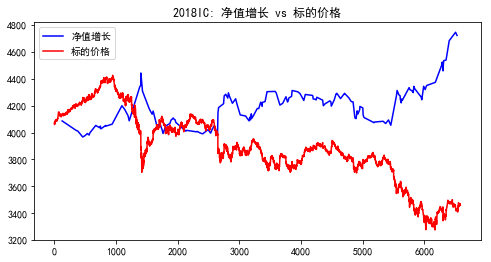

In [109]:
# nn = np.concatenate([[0],neg_profit_rate])
# nn = neg_profit_rate
plt.plot(profit2018['sell_time'],(profit2018['profit_rate']+1).cumprod()*IF['收盘价(元)'].values[21964]
         ,'b',IF['收盘价(元)'].values[21964:],'r')
plt.rcParams['figure.figsize'] = (8, 4) 
plt.legend(['净值增长','标的价格'])
plt.title('2018IC: 净值增长 vs 标的价格')

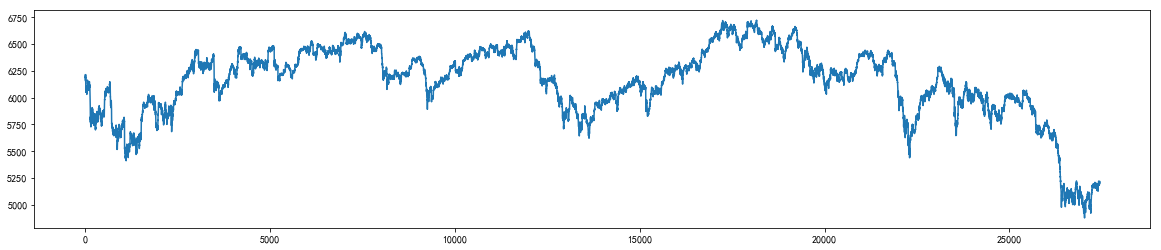

In [36]:
plt.plot(IF['收盘价(元)'].values)

In [111]:
#收益率计算
#2016-18年
#IF 0.05
data = IF_close[0:]
#IC 0.22
# data = IF_close[20864:]
#IH 0.089
# data = IF_close[20064:]
profit_rate = []
sell = []
sell_time = []
buy = []
buy_time = []
diff = []
acc_profit = 0.0

neg_buy = []
neg_sell = []
neg_profit_rate = []

MA10 = np.zeros(len(data))
freq_list = np.empty(len(data))
cyc_list = np.empty(len(data))
n = 40
k = 2
f = np.linspace(0.01,0.99,200)

for i in range(n,len(data)):
#     k,a = find_k(data[i-n:i])
    a = burgs(data[i-n:i],k)
#     fpe = FPE(data[i-n+1:i+1],a)
    sigma = sigma_2(data[i-n:i],k)[0]
#     sigma = np.std(a)
    y = map(lambda x: spectral_density(np.sqrt(sigma),a,x),f)
    y = list(y)
    freq_list[i] = f[np.where(y==max(y))][0]
    cyc_list[i] = 1/freq_list[i]
    if(i >= n+10):
        MA10[i] = min(max(np.mean(cyc_list[i-10:i]),5),30)
        if((MA10[i]>=10) & (MA10[i-1]<10)):#上穿买入
#         if((cyc_list[i]>=10) & (cyc_list[i-1]<10)):
#             print('buy')
            buy_ = IF['收盘价(元)'].values[i-1]
            buy_time_ = i
            if(len(sell)>0):
                buy.append(-sell_)
                buy_time.append(sell_time_)
                sell.append(-buy_)
                sell_time.append(buy_time_)
                profit_rate.append(sell_/buy_-1)
                acc_profit = acc_profit + sell_- buy_
        if((MA10[i]<=10)& (MA10[i-1]>10)):#下穿卖出
#         if((cyc_list[i]<=10) & (cyc_list[i-1]>10)):
#             print('sell')
            sell_ = IF['收盘价(元)'].values[i-1]
            sell_time_ = i
            buy.append(buy_)
            buy_time.append(buy_time_)            
            sell.append(sell_)
            sell_time.append(sell_time_)
            profit_rate.append(sell_/buy_-1)
            acc_profit = acc_profit + sell_- buy_
    if(i%500==0):
        print(i)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500


In [112]:
profit = pd.DataFrame({'profit_rate':profit_rate,'sell':sell,'sell_time':sell_time,'buy':buy,'buy_time':buy_time})
acc_profit,np.sum(profit['profit_rate']),len(profit) 
#2016-2018累计收益点数,累计收益率,交易次数

(970.8000000000084, 0.30967346854780364, 665)

In [73]:
np.sum(profit['profit_rate']<0)

316

In [76]:
hh = profit.iloc[np.where(profit['profit_rate']<0)[0]]
np.mean(hh['profit_rate'])
# np.mean(profit2017['profit_rate'])

-0.007372452004929739

Text(0.5,1,'2016-2018IC: 净值增长 vs 标的价格')

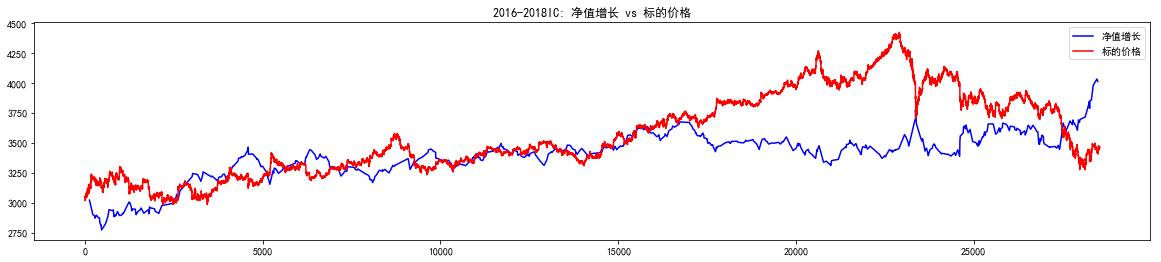

In [114]:
# nn = np.concatenate([[0],neg_profit_rate])
# nn = neg_profit_rate
plt.plot(profit['sell_time'],(profit['profit_rate']+1).cumprod()*IF['收盘价(元)'].values[0]
         ,'b',IF['收盘价(元)'].values[0:],'r')
plt.rcParams['figure.figsize'] = (20, 4) 
plt.legend(['净值增长','标的价格'])
plt.title('2016-2018IC: 净值增长 vs 标的价格')